# Autoencoder

In dit notebook maken en trainen we een autoencoder voor de `mnist` dataset.
We gebruiken deze vervolgens om nieuw afbeeldingen van handgeschreven letters te genereren.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 3 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

In [92]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam

### verover de data

In [93]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Afbeeldingen zijn 28x28 pixels in zwart/wit (1 kanaal).

We projecteren iedere afbeelding naar 2 getallen.

In [94]:
input_dim = (28, 28, 1)
z_dim = 2

### Encoder

We maken eerst een `encoder`. We maken hiervoor gebruik van de functionele notatie van Keras. De `encoder` is in essentie een CNN dat een afbeelding terugbrengt tot twee getallen.

In [95]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_2')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_3')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_5')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_6')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_7')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary` van het model. Komt deze samenvatting overeen met jouw verwachtingen?

In [96]:
encoder.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_4 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_93 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_5 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_94 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_6 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_95 (LeakyReLU)  (None, 7, 7, 64)          0  

### Decoder

Nu maken we een `decoder`. Deze vertaalt een representatie bestaande uit twee getallen naar een afbeelding.
Hiervoor gebruiken we `Conv2DTranspose` lagen.

In [119]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 32,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary`. Merk op dat de output van de laatste laag de afmetingen heeft van een afbeelding uit de `mnist` dataset. De `decoder` is een gespiegelde versie van de `encoder`, dit is echter niet noodzakelijk, de enige eis is dat het netwerk op basis van twee getallen een afbeelding kan genereren.

In [120]:
decoder.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_15 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_15 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_125 (LeakyReLU)  (None, 7, 7, 64)         0         
                                                                 
 decoder_conv_t_2 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                  

### De volledige autoencoder

De autoencoder koppelt de `encoder` en de `decoder`. Door deze samen te trainen en als loss functie de *mean squared error* tussen de originele afbeelding (input van de encoder) en de output van de decoder te nemen, optimaliseert de autoencoder de gewichten van beide onderdelen voor het reconstrueren van afbeeldingen.

In [121]:
autoencoder = Model(encoder_input, decoder(encoder_output))

Compileer en train de `autoencoder`.

In [122]:
learning_rate = 0.0005

optimizer = Adam(learning_rate = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = optimizer, loss = r_loss)

Merk op dat in onderstaande code de labels gelijk zijn aan de inputs.

In [123]:
subset = 3000

autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 20, shuffle = True)

Epoch 1/20
94/94 [==============================] - 4s 39ms/step - loss: 0.0953
Epoch 2/20
94/94 [==============================] - 4s 38ms/step - loss: 0.0586
Epoch 3/20
94/94 [==============================] - 4s 39ms/step - loss: 0.0573
Epoch 4/20
94/94 [==============================] - 4s 40ms/step - loss: 0.0565
Epoch 5/20
94/94 [==============================] - 4s 40ms/step - loss: 0.0559
Epoch 6/20
94/94 [==============================] - 4s 38ms/step - loss: 0.0554
Epoch 7/20
94/94 [==============================] - 4s 41ms/step - loss: 0.0549
Epoch 8/20
94/94 [==============================] - 4s 45ms/step - loss: 0.0543
Epoch 9/20
94/94 [==============================] - 4s 40ms/step - loss: 0.0540
Epoch 10/20
94/94 [==============================] - 4s 40ms/step - loss: 0.0533
Epoch 11/20
94/94 [==============================] - 4s 38ms/step - loss: 0.0527
Epoch 12/20
94/94 [==============================] - 4s 43ms/step - loss: 0.0522
Epoch 13/20
94/94 [==================

In [124]:
# print de aantal labels en de aantal inputs
print(y_test.shape)
print(x_test.shape)


(10000,)
(10000, 28, 28, 1)




### Reconstructie van originele afbeeldingen

Laten we nu eens kijken wat voor resultaten de `autoencoder` oplevert. Om te beginnen kijken we hoe goed de `decoder` in staat is om afbeeldingen te reconstrueren.

We selecteren willekeurige afbeeldingen uit de testset, coderen deze met de `encoder` en decoderen deze met de `decoder`.

1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 132ms/step


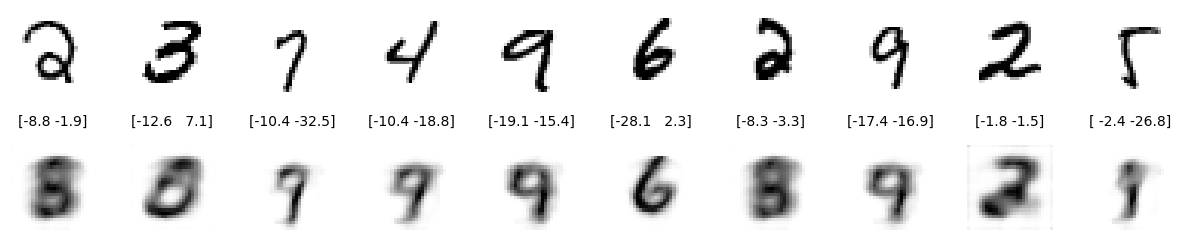

In [125]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Bovenstaande plot laat op de bovenste rij de originele afbeeldingen zien en daaronder telkens de door de decoder gereconstrueerde afbeelding.

Wat valt je op aan de reconstructies?

<b>

Het model maakt best wel fouten, zelfs meer dan de helft. Daarnaast zijn de plots van de decoder wazig waardoor ik het getal moeilijk kan classifcieren. `bewering voor de verbeteringen`

Om een beter beeld te krijgen van het gedrag van de autoencoder, plotten we de outputs van de encoder (de 'z-waarden') voor een deel van de testset. De kleur van een punt geeft het correcte label weer.

Daarnaast selecteren we alvast een aantal willekeurige punten (dus een combinatie van twee willekeurige getallen) die we dadelijk gaan gebruiken om volledig nieuwe afbeeldingen te genereren. Deze punten worden in het rood weergegeven.

  1/157 [..............................] - ETA: 3s

157/157 [==============================] - 1s 6ms/step


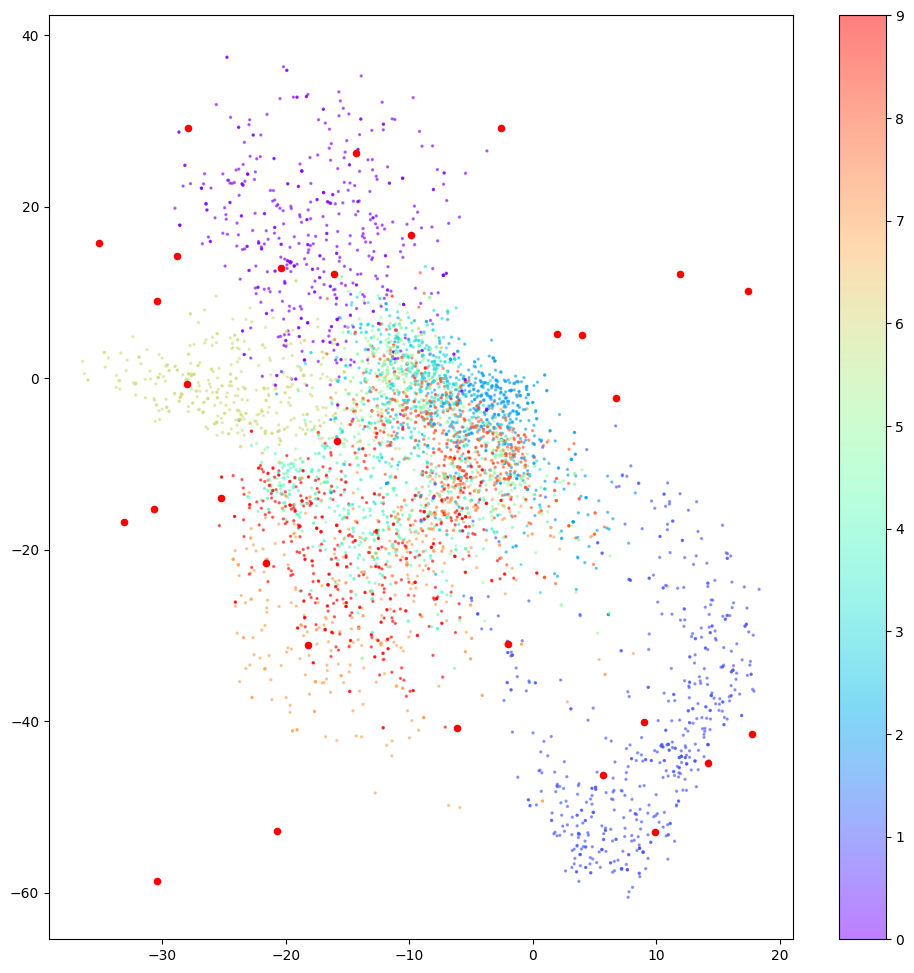

In [126]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

Wat valt je op aan bovenstaande plot met betrekking tot de verdeling van de labels?

Wat valt je op aan bovenstaande plot met betrekking tot de willekeurig geselecteerde punten?

<b> 

`bewering voor de verbeteringen`

* Ik merk op dat er een aanzienlijk aantal labels tussen 2 en 5 liggen in de bovenstaande plot met betrekking tot de labelverdeling.

* Het valt me op dat meer dan de helft van de willekeurig geselecteerde punten tussen 2 en 4 liggen in de bovenstaande plot.

We gebruiken nu de `decoder` om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

1/1 [==============================] - 0s 27ms/step


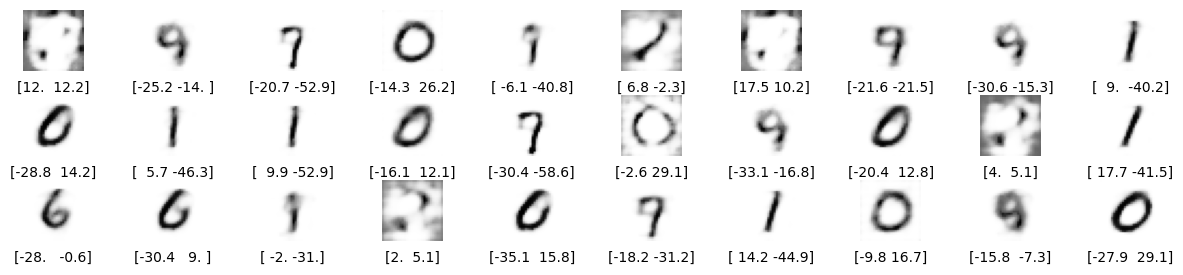

In [127]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

Wat valt je op aan deze afbeeldingen?

<b>

Het eerste wat me opvalt dat er veel nullen staan, wat ik eigenlijk niet had verwacht.

Varieer nu eens met het aantal lagen en filters in de `encoder` en `decoder`. Kun je de `decoder` een volledig andere vorm geven dan de `encoder`? Hoe beïnvloed dit het resultaat?

<b>

Ja, ik kan de encoder en decoder verschillende vormen geven door te variëren met het aantal lagen en filters. Het is niet noodzakelijk dat de decoder dezelfde structuur heeft als de encoder. Ze kunnen verschillende architectuur hebben zolang de dimensies van de input en output overeenkomen.